<h1>Inhaltsverzeichnis<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#C.-Portfolio-Management" data-toc-modified-id="C.-Portfolio-Management-1">C. Portfolio Management</a></span></li><li><span><a href="#C.2-Ermittlung-der-Effizienzkurve" data-toc-modified-id="C.2-Ermittlung-der-Effizienzkurve-2">C.2 Ermittlung der Effizienzkurve</a></span><ul class="toc-item"><li><span><a href="#1.-Monte-Carlo-Simulation" data-toc-modified-id="1.-Monte-Carlo-Simulation-2.1">1. Monte Carlo Simulation</a></span></li><li><span><a href="#2.-Numerische-Optimierung" data-toc-modified-id="2.-Numerische-Optimierung-2.2">2. Numerische Optimierung</a></span></li><li><span><a href="#3.-Das-minimale-Value-at-Risk-(VaR)-Portfolio" data-toc-modified-id="3.-Das-minimale-Value-at-Risk-(VaR)-Portfolio-2.3">3. Das minimale Value at Risk (VaR) Portfolio</a></span></li></ul></li></ul></div>

# C. Portfolio Management
# C.2 Ermittlung der Effizienzkurve
## 1. Monte Carlo Simulation
In diesem Abschnitt werden wir uns mit grundlegenden Methoden der Portfolio-Optimierung befassen und dabei sowohl die Verwendung von Monte Carlo Simulationen, die sog. "Brute-Force"-Optimierung, als auch die Verwendung der Scipy-Funktion "optimize" zur Optimierung von Zielfunktionen unter Nebenbedingungen (https://docs.scipy.org/doc/scipy/reference/optimize.html) kennenlernen.

Angenommen wir möchten ein Portfolio aus Aktien so aufbauen, dass die Portfoliogewichte den "optimalen" Gewichten entsprechen. Hierbei ist mit "optimal" das Portfolio mit der höchsten Sharpe-Ratio gemeint. Dieses wird auch als $\mu$ - $\sigma$ effizientes Portfolio bezeichnet.

Der erste Weg ist ein Monte-Carlo-Ansatz im Stil einer "brute force" Simulation. Bei diesem Ansatz wird versucht, die optimalen Gewichte zu ermitteln, indem eine große Anzahl von zufälligen Portfolios mit unterschiedlichen Kombinationen der Gewichtung einzelner Aktien erstellt wird. Für jedes der so simulierten Portfolios wird die Sharpe Ratio berechnet, und das Portfolio mit der höchsten Sharpe Ratio besitzt folgerichtig die optimalen Gewichte.

Die Zufallsgewichtungen, die wir in diesem Beispiel erstellen, sind an Bedingungen gebunden. Sie müssen zwischen null und eins für jede einzelne Aktie liegen und die Summe der Gewichte muss eins betragen, um eine Investition von 100% unseres theoretischen Kapitals darzustellen.

Je mehr zufällige Portfolios wir erstellen für die wir die Sharpe-Ratio berechnen, desto näher kommen wir an die Gewichte des "wahren" optimalen Portfolios, zumindest theoretisch. Es wird jedoch immer einige Abweichungen geben, da wir nie ausreichend viele Portfolios simulieren können, um die exakten Gewichtungen nach denen wir suchen, zu replizieren ... es handelt sich ausschließlich um Annäherungen.

In diesem Beispiel werden wir ein Portfolio aus 5 Aktien betrachten und 100.000 simulierte Portfolios und die dazugehörigen Charakteristika (erwartete Rendite, Standardabweichung, Sharpe-Ratio, etc.) berechnen. Die Portfolios werden dann grafisch dargestellt, und sowohl das "optimale" Portfolio mit der höchsten Sharpe-Ratio als auch das Portfolio mit minimaler Varianz werden hervorgehoben und markiert, um sie einfacher identifizieren zu können. Das Portfolio mit minimaler Varianz (Low Risk Portfolio) ist, wie der Name schon sagt, das Portfolio mit der niedrigsten simulierten Varianz (das per Definition auch die geringste simulierte Standardabweichung oder "Volatilität" aufweist).

Starten wir nun mit dem Coding!

Wie immer beginnen wir mit dem Import der benötigten Bibliotheken und Daten.

In [1]:
import pandas as pd  
import numpy as np
import pandas_datareader.data as web
from datetime import datetime
import scipy.optimize as sco
import matplotlib.pyplot as plt
%matplotlib inline

Wir laden dann die Kursdaten für die Aktien herunter, die wir in unser Portfolio aufnehmen möchten. In diesem Beispiel habe ich 5 Aktien nach dem Zufallsprinzip ausgewählt, deren Namen die meisten Menschen sicher schon einmal gehört haben... Apple, Microsoft, Netflix, Amazon und Google.

In [2]:
#download stock portfolio data
tickers = ['AAPL', 'AMZN', 'GOOG', 'MSFT', 'NFLX']
start = datetime(2010, 1, 1)
end = datetime(2018, 12, 31)

df = pd.DataFrame([web.get_data_yahoo(ticker, start, end)['Adj Close'] for ticker in tickers]).T
df.columns = tickers

In [3]:
df

,AAPL,AMZN,GOOG,MSFT,NFLX
Date,,,,,
2010-01-04,6.515212,6.695000,15.610239,23.683071,7.640000
2010-01-05,6.526476,6.734500,15.541497,23.690729,7.358571
2010-01-06,6.422665,6.612500,15.149715,23.545332,7.617143
2010-01-07,6.410791,6.500000,14.797037,23.300472,7.485714
2010-01-08,6.453413,6.676000,14.994298,23.461164,7.614286
...,...,...,...,...,...
2018-12-24,35.429188,67.197998,48.811001,90.178169,233.880005
2018-12-26,37.924175,73.544998,51.973000,96.338181,253.669998
2018-12-27,37.678051,73.082001,52.194000,96.932175,255.570007


Wir erhalten unsere Ergebnisse durch die Definition und Ausführung zweier Funktionen (siehe unten). Die erste Funktion (**calc_portfolio_perf**) wird verwendet, um uns bei der Berechnung der annualisierten erwarteten Rendite, der annualisierten Standardabweichung und der annualisierten Sharpe-Ratio eines Portfolios zu unterstützen, wobei wir natürlich bestimmte Argumente definieren müssen. Die Argumente, die wir definieren werden, sind die Portfoliogewichte der Aktien, die mittlere tägliche Rendite jeder Aktie (berechnet anhand der historischen Daten, die wir zuvor heruntergeladen haben), die Kovarianzmatrix der Aktien und schließlich der risikofreie Zinssatz. Der risikofreie Zinssatz wird für die Berechnung der Sharpe-Ratio benötigt und sollte als annualisierter Wert angegeben werden. In diesem Beispiel verwende ich zur Vereinfachung einen Zinssatz von Null. Die Funktionalität ist jedoch vorhanden, um den risikolosen Zinssatz auf jeden beliebigen Wert zu setzen.

Die zweite Funktion befasst sich mit der Erstellung mehrerer zufällig gewichteter Portfolios, die dann an die oben beschriebene Funktion weitergegeben werden, um die erforderlichen Portfoliocharakteristika zu berechnen, die wir speichern möchten. Nachdem alle Portfolios simuliert worden sind, werden die gespeicherten Ergebnisse in einem Pandas DataFrame erfasst und wiedergegeben.

Die erfassten Portfoliocharakteristika sind, wie bereits erwähnt, die annualisierte Rendite, die annualisierte Standardabweichung und die annualisierte Sharpe-Ratio - wir speichern auch die Gewichte der einzelnen Aktien im Portfolio, die diese Werte generiert haben.

In [4]:
def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios)) #8Zeilen; 3 für Ergebnisse & 5 für Gewichtungen #2Klammern(Matrix), sonst Vektor
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns)) #erstellt 5 Zufallswerte zw 0 & 1
        weights /= np.sum(weights) #weights = weights/np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])
        
    return results_df


In [47]:
results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
results_matrix

matrix= np.zeros((4,12))
matrix

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

Jetzt berechnen wir die Durchschnittsrenditen und die Kovarianzmatrix unserer Aktien, legen die Anzahl der Portfolios fest, die wir simulieren möchten und legen schließlich den gewünschten Wert des risikofreien Zinssatzes fest. Dann rufen wir die gewünschte Funktion auf und speichern die Ergebnisse in einer Variablen, damit wir sie anschließend extrahieren und visualisieren können.

In [5]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

In [6]:
results_frame

,ret,stdev,sharpe,AAPL,AMZN,GOOG,MSFT,NFLX
0,0.367583,0.287444,1.278799,0.286892,0.288039,0.048253,0.003745,0.373070
1,0.237264,0.221046,1.073372,0.040072,0.258816,0.468748,0.158858,0.073505
2,0.276832,0.221082,1.252170,0.344104,0.216568,0.232966,0.058183,0.148180
3,0.321496,0.247660,1.298135,0.206772,0.396994,0.027018,0.158404,0.210812
4,0.354168,0.289112,1.225022,0.062372,0.297315,0.198437,0.072469,0.369407
...,...,...,...,...,...,...,...,...
99995,0.218932,0.197314,1.109562,0.351210,0.039611,0.238800,0.318225,0.052153
99996,0.226634,0.200516,1.130250,0.218502,0.146213,0.291432,0.290559,0.053294
99997,0.303860,0.257488,1.180092,0.154260,0.020843,0.368888,0.124648,0.331360
99998,0.262546,0.222601,1.179447,0.103865,0.360221,0.242449,0.208833,0.084632


Im Folgenden werden die Ergebnisse aller simulierten Portfolios visualisiert, wobei jedes Portfolio nach den entsprechenden Werten der annualisierten Rendite (y-Achse) und der annualisierten Volatilität (x-Achse) abgebildet wird. Das Portfolio mit maximaler Sharpe-Ratio wird durch einen roten Stern und das Portfolio mit minimaler Varianz durch einen grünen Stern gekennzeichnet.

Die Datenpunkte sind entsprechend ihrer jeweiligen Sharpe-Ratio eingefärbt, wobei Blau für einen höheren und Rot für einen niedrigeren Wert steht.

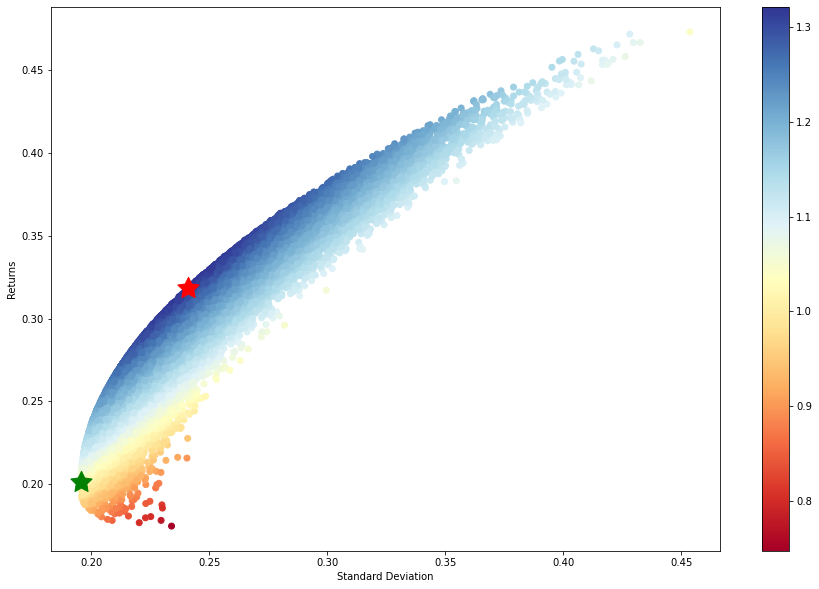

In [7]:
#locate position of portfolio with highest Sharpe Ratio
max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]
#locate positon of portfolio with minimum standard deviation
min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

#create scatter plot coloured by Sharpe Ratio
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.sharpe,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of portfolio with highest Sharpe Ratio
plt.scatter(max_sharpe_port[1],max_sharpe_port[0],marker=(5,1,0),color='r',s=500)
#plot green star to highlight position of minimum variance portfolio
plt.scatter(min_vol_port[1],min_vol_port[0],marker=(5,1,0),color='g',s=500)
plt.show()


Jetzt werfen wir noch einen Blick auf die Gewichtung der Aktien, aus denen diese beiden Portfolios bestehen, sowie auf die annualisierte Rendite, die annualisierte Standardabweichung und die annualisierte Sharpe-Ratio. Diese werden im Folgenden zunächst für das maximale Sharpe-Portfolio und dann für das Portfolio mit minimaler Varianz dargestellt.

In [8]:
max_sharpe_port.to_frame().T

,ret,stdev,sharpe,AAPL,AMZN,GOOG,MSFT,NFLX
35938,0.318559,0.241142,1.32104,0.375954,0.254199,0.001688,0.134374,0.233786


In [9]:
min_vol_port.to_frame().T

,ret,stdev,sharpe,AAPL,AMZN,GOOG,MSFT,NFLX
56334,0.201605,0.195626,1.030563,0.288764,0.031676,0.278843,0.383945,0.016771


## 2. Numerische Optimierung
Als nächstes beginnen wir mit dem zweiten Optimierungsansatz, der die Scipy-Funktionen verwendet. Der Code ist ziemlich kurz, aber es gibt ein paar erwähnenswerte Besonderheiten. Erstens bietet Scipy eine "Minimieren"-Funktionalität, aber keine "Maximieren"-Funktion. Wenn wir sagen, dass wir die Sharpe-Ratio maximieren möchten, mag dies auf den ersten Blick wie ein kleines Problem erscheinen, aber es lässt sich leicht lösen, wenn man sich klar macht, dass die Maximierung der Sharpe-Ratio analog zur Minimierung der negativen Sharpe-Ratio ist - also buchstäblich nur der Sharpe-Ratio-Wert mit einem vorangestellten Minuszeichen.

Zuerst definieren wir also eine Funktion (sehr ähnlich unserer vorangehenden Funktion), die die negative Sharpe-Ratio eines Portfolios berechnet und ausgibt.

Dann definieren wir eine Variable, die ich als "constraints" bezeichnet habe. Das kann zunächst etwas merkwürdig anmuten, wenn Sie die "Optimierungs"-Fähigkeiten von Scipy noch nicht benutzt haben.

Lassen Sie uns die einzelnen Einträge durchgehen um sie besser zu verstehen:

Da wir die "SLSQP"-Methode in unserer "Minimieren"-Funktion verwenden werden (was für "Sequential Least Squares Programming" steht), muss das Constraints Argument das Format eines Tupels von Dictionaries haben, die die Felder "type" und "fun" mit den optionalen Feldern "jac" und "args" enthält. Wir brauchen nur die Felder "type", "fun" und "args". Ein Tupel ist eine unveränderliche Sequenz fester Länge aus Pyython-Objekten, eingebettet in runde Klammern () wobei die einzelnen Objekte kommasepariert sind.

Der "type" kann entweder "eq" oder "ineq" sein, was sich auf "equality" bzw. "inequality" bezieht. Das "fun" bezieht sich auf die Funktion, die die Beschränkung definiert, in unserem Fall die Beschränkung, dass die Summe der Aktiengewichte 1 sein muss. Die Art und Weise, wie dies eingegeben werden muss, ist etwas umständlich. Das "eq" bedeutet, dass wir nach einer Funktion suchen, deren Ausgabewert gleich Null ist (das ist es, worauf sich die Gleichheit bezieht - Gleichheit mit Null). Der einfachste Weg, dies zu erreichen, besteht darin, eine Lambda-Funktion zu erstellen, die die Summe der Portfolio-Gewichte minus 1 liefert. Die Beschränkung, dass der Ausgabewert dieser Funktion gleich Null sein muss, bedeutet per Definition, dass die Gewichte zu 1 summiert werden müssen.

Die "bounds" legen lediglich fest, dass jedes einzelne Aktiengewicht zwischen 0 und 1 liegen muss, wobei die "args" die Argumente sind, die wir an die Funktion übergeben wollen, die wir zu minimieren versuchen (calc_neg_sharpe) - das sind alle Argumente AUßER dem Gewichtungsvektor, der natürlich die Variable ist, die wir zur Optimierung der Ausgabe ändern.

In [10]:
def calc_neg_sharpe(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return -sharpe_ratio

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def max_sharpe_ratio(mean_returns, cov, rf):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, rf)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_neg_sharpe, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

optimal_port_sharpe = max_sharpe_ratio(mean_returns, cov, rf)


In [11]:
optimal_port_sharpe

     fun: -1.3217801966158194
     jac: array([ 1.13263726e-04, -2.41398811e-06,  1.24996647e-01,  3.97711992e-05,
       -1.94460154e-04])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.35144708, 0.27150186, 0.        , 0.1459197 , 0.23113136])

Wenn wir die Optimierung durchführen, erhalten wir die folgenden Ergebnisse:

In [12]:
pd.DataFrame([round(x,2) for x in optimal_port_sharpe['x']],index=tickers).T

,AAPL,AMZN,GOOG,MSFT,NFLX
0,0.35,0.27,0.0,0.15,0.23


Wenn wir diese Ergebnisse mit denen unseres Monte-Carlo-Ansatzes vergleichen, können wir feststellen, dass sie ähnlich sind, aber natürlich werden sie, wie oben erläutert, nicht identisch sein. Die Gewichtungen der einzelnen Aktien liegen nicht mehr als ein paar Prozent auseinander zwischen den beiden Ansätzen ... dies deutet darauf hin, dass wir bisher alles richtig gemacht haben!

Wir können dann einfach den gleichen Ansatz verwenden, um das Portfolio mit minimalen Varianz zu identifizieren. Es ist fast derselbe Code wie oben, obwohl wir dieses Mal eine Funktion definieren müssen, um die Volatilität eines Portfolios zu berechnen und auszugeben und sie als die Funktion verwenden müssen, die wir minimieren wollen ("calc_portfolio_std"). Diesmal besteht keine Notwendigkeit, die Ausgabe unserer Funktion zu negieren, da es sich diesmal bereits um ein Minimierungsproblem handelt (im Gegensatz zur Sharpe-Ratio, als wir das Maximum finden wollten).

Die Nebenbedingungen bleiben die gleichen, also passen wir einfach die obige Funktion "max_sharpe_ratio" an, benennen sie in "min_variance" um und ändern die Variable "args" so, dass sie die richtigen Argumente enthält, die wir an unsere neue "calc_portfolio_std" übergeben müssen, die wir minimieren.

In [13]:
def calc_portfolio_std(weights, cov):
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    return portfolio_std

def min_variance(cov):
    num_assets = len(cov)
    args = cov
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_std, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_variance = min_variance(cov)

In [14]:
min_port_variance

     fun: 0.19559397396823103
     jac: array([0.19542688, 0.19557868, 0.19589013, 0.19546526, 0.1965204 ])
 message: 'Optimization terminated successfully'
    nfev: 54
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([0.28282934, 0.02476468, 0.27332849, 0.39952298, 0.01955451])

Wenn wir die Optimierung durchführen, erhalten wir die folgenden Ergebnisse:

In [15]:
pd.DataFrame([round(x,2) for x in min_port_variance['x']],index=tickers).T

,AAPL,AMZN,GOOG,MSFT,NFLX
0,0.28,0.02,0.27,0.4,0.02


Auch hier sehen wir, dass die Ergebnisse sehr nahe an den Ergebnissen liegen, die uns bei der Anwendung des Monte-Carlo-Ansatzes angezeigt wurden.

## 3. Das minimale Value at Risk (VaR) Portfolio

Kommen wir nun zu dem Problem das sich bei der Ermittlung der Portfoliogewichte ergibt, die den Value at Risk (VaR) minimieren. Der VaR ist dabei definiert als das Alpha-Quantil der Renditeverteilung. Beträgt Alpha beispielsweise 5%, gibt der VaR diejenige Rendite an, die das Portfolio über den vorgegebenen Risikohorizont mit der Wahrscheinlichkeit von 5% erreicht oder unterschreitet. 

Die hier verwendete Logik ist der Monte-Carlo-Logik sehr ähnlich. Folglich werden nur die Veränderungen und Unterschiede herausgearbeitet. Wir beginnen erneut mit der Erstellung unserer beiden Funktionen - aber dieses Mal wird anstelle einer Funktion, die die Portfoliorendite, die Volatilität und die Sharpe-Ratio ausgibt, der parametrische Portfolio-VaR auf einem spezifischen Konfidenzniveau, das durch den Wert des "Alpha"-Arguments bestimmt wird (das Konfidenzniveau ist 1 - Alpha), und für einen Zeithorizont, der durch das "days"-Argument festgelegt wird, erzeugt.

Unter der Annahme, dass die Portfoliorenditen einer Normalverteilung folgen, kann der Portfolio-VaR wie folgt berechnet werden:


$$ VaR(\alpha) = \mu_{p} - Q_{z}(1-\alpha){\sigma_{p}} $$

mit $\mu_{p}$ = Mittelwert der Portfoliorendite, $Q_{z}(1-\alpha)$ = $(1-\alpha)$-Quantil der Standardnormalverteilung, und $\sigma_{p}$ = Volatilität der Portfoliorendite. 

Um einen annualisierten VaR zu berechnen, wird zunächst die Portfolio-Standardabweichung mit der Quadratwurzel des "days"-Wertes multipliziert. Diese Zahl, multipliziert mit dem entsprechenden Quantil der Standardnormalverteilung gemäß dem festgelegten Wert von "Alpha", wird dann von den Portfolio-Tagesdurchschnittsrenditen abgezogen, die linear entsprechend dem "days"-Wert skaliert wurden. Dieser endgültige VaR-Wert wurde dann in einen absoluten Wert umgewandelt, da der VaR in den meisten Fällen als positiver Wert angegeben wird (dies ermöglicht uns auch die Berechnung der erforderlichen "Minimierungs"-Funktion, wenn der VaR als positiver Wert angegeben wird).

Es sei angemerkt, dass der VaR manchmal so berechnet wird, dass die mittleren Renditen des Portfolios als klein genug angesehen werden, dass sie mit einem Nullwert in die Gleichung eingehen können - dies ist in der Regel sinnvoller, wenn wir den VaR über kurze Zeiträume (wie Tage oder Wochen) betrachten; wenn wir jedoch beginnen, annualisierte VaR-Werte zu berechnen, macht es Sinn, ein "Nicht-Null"-Rendite-Element einzubeziehen.

Jedoch wird der obige Ansatz, bei dem die Renditen als Null eingegeben werden (und damit effektiv aus der Berechnung entfernt werden), manchmal bevorzugt, da er eine "pessimistischere" Sicht des VaR eines Portfolios darstellt und es ratsam ist, bei der Quantifizierung des Risikos bzw. bei jeder "Abwärts"-Prognose auf konservative Weise zu messen und Entscheidungen auf der Grundlage eines Worst-Case-Szenarios zu treffen. Die Kosten eines Irrtums aufgrund einer Unterschätzung des VaR und die Kosten einer Überschätzung des VaR sind fast nie symmetrisch - eine Unterschätzung verursacht fast immer höhere Kosten.

Die zweite Funktion ist ziemlich ähnlich zu der, die für die Sharpe-Optimierung verwendet wurde, mit einigen leichten Änderungen der Variablennamen, Parameter und Argumente.

In [16]:
from scipy import stats
def calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_return, portfolio_std, portfolio_var


def simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, portfolio_VaR = calc_portfolio_perf_VaR(weights, mean_returns, cov, alpha, days)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = portfolio_VaR
        #iterate through the weight vector and add data to results array
        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]
            
    results_df = pd.DataFrame(results_matrix.T,columns=['ret','stdev','VaR'] + [ticker for ticker in tickers])
        
    return results_df


In Ergänzung zu den bisherigen Variablen werden die beiden Variablen "days" und "Alpha" definiert. Die "days"-Variable bestimmt den Zeithorizont, für den der VaR-Wert berechnet/skaliert wird, und die "Alpha"-Variable ist das Signifikanzniveau, das für die Berechnung verwendet wird (wobei das Konfidenzniveau (1 - Signifikanzniveau) ist, wie oben bereits erwähnt).

Ich habe 252 Tage (Handelstage eines Jahres) und einen Alpha-Wert von 0,05 gewählt, was einem Konfidenzniveau von 95% entspricht. Das heißt also, wir werden den einjährigen VaR zum Niveau 95% berechnen und versuchen, diesen Wert zu minimieren.

Nun lassen wir die Simulationsfunktion laufen und zeichnen die Ergebnisse erneut auf.

In [17]:
mean_returns = df.pct_change().mean()
cov = df.pct_change().cov()
num_portfolios = 100000
rf = 0.0
days = 252
alpha = 0.05

results_frame = simulate_random_portfolios_VaR(num_portfolios, mean_returns, cov, alpha, days)


Wir stellen die Ergebnisse der Portfolios so dar, dass die annualisierte Rendite auf der y-Achse bestehen bleibt, und die x-Achse diesmal den VaR des Portfolios (und nicht die Standardabweichung) abbildet. Der Graph färbt die Datenpunkte entsprechend dem Wert des VaR für ein Portfolio ein.

In [18]:
results_frame

,ret,stdev,VaR,AAPL,AMZN,GOOG,MSFT,NFLX
0,0.240759,0.202614,0.092511,0.418783,0.069978,0.133174,0.290882,0.087182
1,0.313144,0.254147,0.104890,0.093794,0.170368,0.244425,0.190422,0.300991
2,0.305544,0.232807,0.077388,0.275505,0.271150,0.028349,0.219829,0.205167
3,0.310562,0.251143,0.102532,0.136050,0.239232,0.291447,0.068570,0.264702
4,0.255562,0.211580,0.092457,0.375082,0.004502,0.242587,0.211997,0.165832
...,...,...,...,...,...,...,...,...
99995,0.278746,0.221293,0.085248,0.177344,0.247646,0.177302,0.237730,0.159978
99996,0.303936,0.233689,0.080449,0.288306,0.352569,0.047136,0.143000,0.168989
99997,0.266213,0.229461,0.111217,0.038359,0.144735,0.405001,0.216808,0.195096
99998,0.308153,0.244325,0.093726,0.108912,0.410725,0.099514,0.196032,0.184818


In [19]:
results_frame.iloc[results_frame['VaR'].idxmin()]

ret      0.297301
stdev    0.226452
VaR      0.075180
AAPL     0.342874
AMZN     0.244325
GOOG     0.009678
MSFT     0.220690
NFLX     0.182433
Name: 70137, dtype: float64

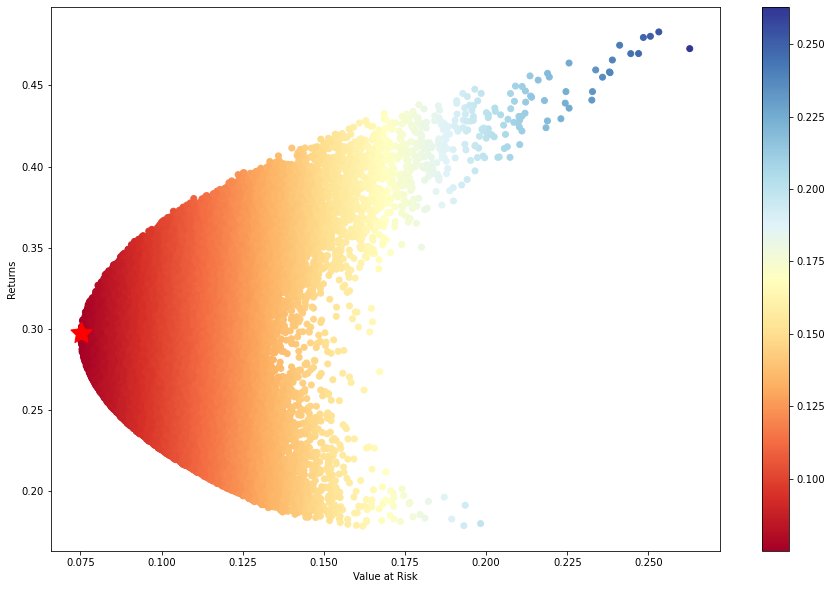

In [20]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]

#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.VaR,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Value at Risk')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[2],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()


Die Gewichte des Min.-VaR-Portfolios sind unten angegeben.

In [21]:
min_VaR_port.to_frame().T

,ret,stdev,VaR,AAPL,AMZN,GOOG,MSFT,NFLX
70137,0.297301,0.226452,0.07518,0.342874,0.244325,0.009678,0.22069,0.182433


So weit, so gut ... was passiert, wenn wir die Lage des Min.-VaR-Portfolios in einem Diagramm mit der y-Achse als Rendite und der x-Achse als Standardabweichung wie bisher darstellen? Die Datenpunkte werden nach wie vor entsprechend ihrem VaR-Wert eingefärbt.

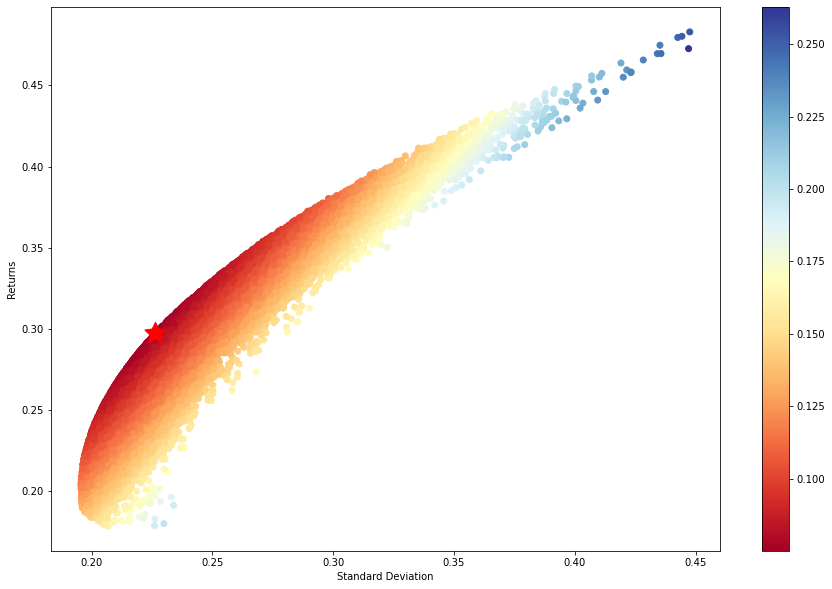

In [22]:
#locate positon of portfolio with minimum VaR
min_VaR_port = results_frame.iloc[results_frame['VaR'].idxmin()]

#create scatter plot coloured by VaR
plt.subplots(figsize=(15,10))
plt.scatter(results_frame.stdev,results_frame.ret,c=results_frame.VaR,cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

#plot red star to highlight position of minimum VaR portfolio
plt.scatter(min_VaR_port[1],min_VaR_port[0],marker=(5,1,0),color='r',s=500)
plt.show()


Nun werden Sie an dieser Stelle vielleicht feststellen, dass die Ergebnisse der Simulationen des Portfolios mit minimalem VaR denen des Portfolios mit maximaler Sharpe-Ratio ziemlich ähnlich sind, was aber auch angesichts der für den VaR gewählten Berechnungsmethode zu erwarten war.

Die VaR-Berechnung war:

$$ VaR(\alpha) = \mu_{p} - Q_{z}(1-\alpha){\sigma_{p}} $$

mit $\mu_{p}$ = Mittelwert der Portfoliorenditen, $Q_{z}(1-\alpha)$ = $(1-\alpha)$-Quantil der Standardnormalverteilung, und $\sigma_{p}$ = Volatilität der Portfoliorendite. 



Und die Berechnung der Sharpe-Ratio war:

$$ SR = \frac{\mu_{p} - r_{f}}{\sigma_{p}} $$

mit $\mu_{p}$ = Mittelwert der Portfoliorendite, $r_{f}$ = risikofreier Zinssatz, und $\sigma_{p}$ = Volatilität der Portfoliorendite. 


Daraus ist ersichtlich, dass der VaR sinkt, wenn die Portfoliorenditen steigen, und umgekehrt, während die Sharpe-Ratio steigt, wenn die Portfoliorenditen steigen - was also den VaR in Bezug auf die Renditen minimiert, maximiert die Sharpe-Ratio.

In ähnlicher Weise erhöht ein Anstieg der Portfolio-Standardabweichung den VaR, verringert jedoch die Sharpe-Ratio - was also den VaR in Bezug auf die Portfolio-Standardabweichung maximiert, minimiert die Sharpe-Ratio.

Da wir den minimalen VaR und die maximale Sharpe-Ratio anstreben, ist es offensichtlich, dass beide Ziele mit "ähnlichen" Portfolios erreicht werden.

Nun gehen wir zum zweiten Ansatz über, um das Min.-VaR-Portfolio zu ermitteln. Auch hier ist der Code relativ ähnlich dem Optimierungscode, der zur Berechnung des maximalen Sharpe- und des minimalen Varianz-Portfolios verwendet wird, jedoch mit einigen geringfügigen Anpassungen.

Wir benötigen eine neue Funktion, die nur den VaR eines Portfolios berechnet und zurückgibt. Hier ändert sich nichts gegenüber unserer ursprünglichen Funktion, die den VaR berechnet hat, nur dass wir einen einzigen VaR-Wert anstelle der drei ursprünglichen Werte (die zuvor die Portfoliorendite und die Standardabweichung einschlossen) ausgeben.

Die Funktion "min_VaR" verhält sich ähnlich wie die Funktionen "max_sharpe_ratio" und "min_variance", nur mit einigen Anpassungen, um die Argumente nach Bedarf zu ändern. Die constraints sind die gleichen, ebenso wie die bounds usw.

In [23]:
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

def calc_portfolio_VaR(weights, mean_returns, cov, alpha, days):
    portfolio_return = np.sum(mean_returns * weights) * days
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(days)
    portfolio_var = abs(portfolio_return - (portfolio_std * stats.norm.ppf(1 - alpha)))
    return portfolio_var

def min_VaR(mean_returns, cov, alpha, days):
    num_assets = len(mean_returns)
    args = (mean_returns, cov, alpha, days)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(calc_portfolio_VaR, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

min_port_VaR = min_VaR(mean_returns, cov, alpha, days)


In [24]:
min_port_VaR

     fun: 0.07494437938388421
     jac: array([0.07490132, 0.07492964, 0.0870307 , 0.07463225, 0.07545571])
 message: 'Optimization terminated successfully'
    nfev: 42
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([0.35313911, 0.2286964 , 0.        , 0.23709529, 0.1810692 ])

 Wenn wir die Optimierung durchführen, erhalten wir die folgenden Ergebnisse:

In [25]:
pd.DataFrame([round(x,2) for x in min_port_VaR['x']],index=tickers).T

,AAPL,AMZN,GOOG,MSFT,NFLX
0,0.35,0.23,0.0,0.24,0.18


Wieder einmal sehen wir, dass die Ergebnisse sehr nahe an den Ergebnissen liegen, die uns bei der Anwendung des Monte-Carlo-Ansatzes präsentiert wurden, wobei die Gewichte nur wenige Prozent voneinander abweichen.

Wir haben in diesem Kapitel zwei Ansätze (Monte-Carlo-"brute-force"-Ansatz und Numerische Optimierung unter Verwendung der Scipy-Funktion "Minimieren") zur Optimierung eines Portfolios von Aktien auf der Grundlage der Minimierung verschiedener Kostenfunktionen (d.h. der negativen Sharpe-Ratio, der Varianz und des Value at Risk) kennengelernt. Beide Ansätze sind flexibel genug, um sie auf weitere Ziel-/Kostenfunktionen anzuwenden. Probieren Sie es aus! 